In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model


In [ ]:
# Load and pre-process dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')
input_train = input_train / 255
input_test = input_test / 255

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 14, 14, 8)    32          conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization_15[0][0]     
____________________________________________________________________________________________

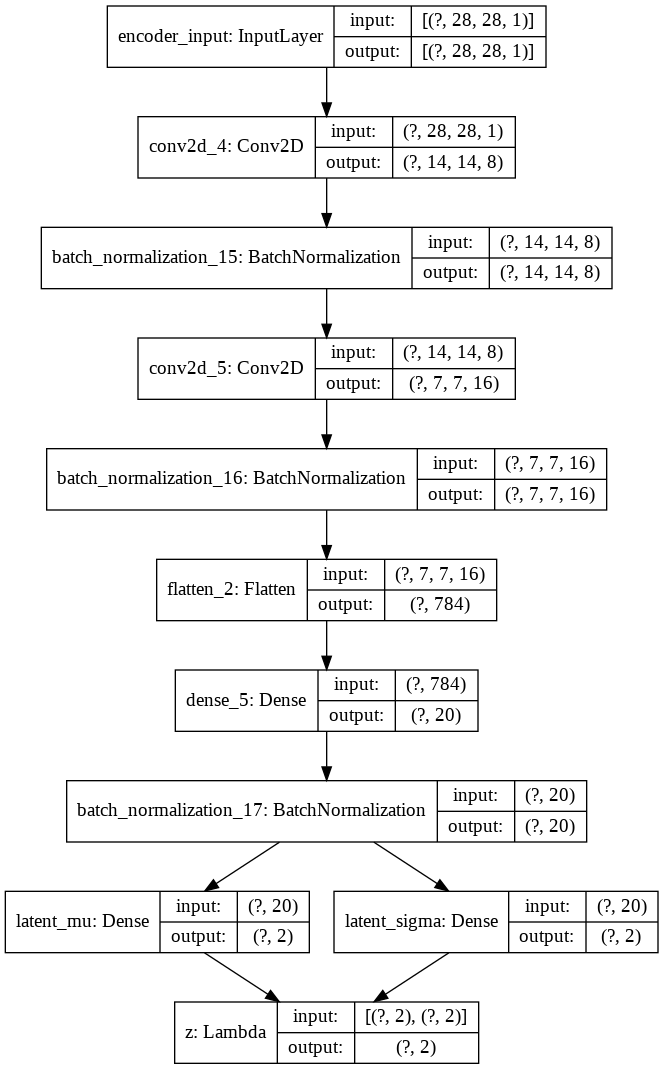

In [ ]:
# # =================
# # Encoder
# # =================
inp       = Input(shape=input_shape, name='enc_inp')
conv      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(inp)
conv      = BatchNormalization()(conv)
conv      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(conv)
conv      = BatchNormalization()(conv)
conv_out       = Flatten()(conv)
conv_out      = Dense(20, activation='relu')(conv_out)
conv_out       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(conv_out)
sigma   = Dense(latent_dim, name='latent_sigma')(conv_out)

conv_shape = K.int_shape(conv)

# reparameterization trick
def sample_dist(args):
  mu, sigma = args
  batchsize     = K.shape(mu)[0]
  dimen       = K.int_shape(mu)[1]
  e       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * e

z       = Lambda(sample_dist, output_shape=(latent_dim, ), name='lamda_z')([mu, sigma])

#  encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               2352      
_________________________________________________________________
batch_normalization_12 (Batc (None, 784)               3136      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 8)         1160

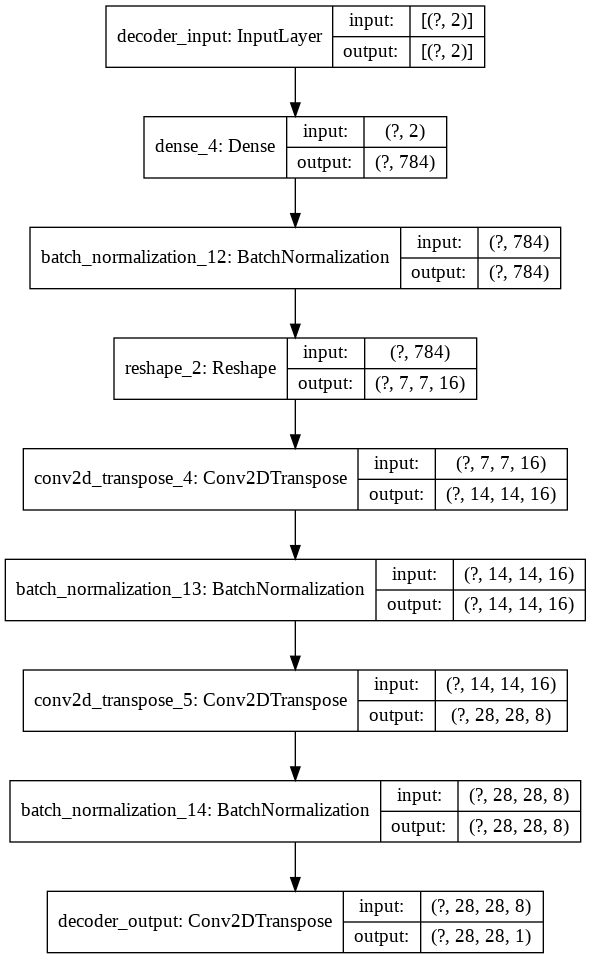

In [ ]:
# =================
# Decoder
# =================

d_inp   = Input(shape=(latent_dim, ), name='decoder_input')
convin     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_inp)
convin    = BatchNormalization()(convin)
convin    = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(convin)
convout    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(convin)
convout    = BatchNormalization()(convout)
convout    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(convout)
convout    = BatchNormalization()(convout)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(convout)

decoder = Model(d_inp, o, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)



In [ ]:
vae_outputs = decoder(encoder(i)[2])
vae_model= Model(i, vae_outputs, name='vae')
vae_model.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 17208     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         9137      
Total params: 26,345
Trainable params: 24,641
Non-trainable params: 1,704
_________________________________________________________________


In [ ]:
# Define loss
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

In [ ]:
# Compile VAE
vae_model.compile(optimizer='adam', loss=kl_reconstruction_loss)
tf.config.experimental_run_functions_eagerly(True)
# Train autoencoder
vae_model.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


375/375 [==============================] - 86s 229ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/100
375/375 [==============================] - 86s 228ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100
116/375 [========>.....................] - ETA: 58s - loss: 0.0000e+00

ResourceExhaustedError: ignored

In [ ]:
#Reconstruction
plt.ioff()
plt.figure(figsize=(5,1))
for i in range(10):
    plt.subplot(2,10, i+1,)
    img = np.reshape(x_test[i], (image_size, image_size))
    plt.axis('off')
    plt.imshow(img, cmap = 'gray_r')

    plt.subplot(2,10, i + 11)
    encoder_input = np.expand_dims(x_test[i], axis = 0)
    mean, var, z = encoder.predict(encoder_input)
    decoded_output = decoder.predict(mean)
    img = np.reshape(x_test[0], (image_size, image_size))
    plt.axis('off')
    plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')
plt.savefig('mnist_reproduction.png')

In [ ]:
#Sampling
def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)